In [1]:
cd /content/drive/MyDrive/Colab Notebooks/VAE

/content/drive/MyDrive/Colab Notebooks/VAE


In [2]:
filename = ''

In [3]:
pip install tensorboardX

     |████████████████████████████████| 317kB 20.2MB/s 


In [4]:
import torch
from torch import nn, optim  
from torch.nn import functional as F
import pandas as pd
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import Logger
from IPython import display

In [17]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/datasets", train=True, transform=transform, download=True
) 

In [18]:
n_features = 28*28
img_size = 28
distrib_features = 32

In [19]:
logger = Logger(model_name='VAE', data_name='MNIST')

In [20]:
n_filter = 64

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(len(x), self.shape[0], self.shape[1])

class DCVAutoEncoder(nn.Module):
  def __init__(self):
    super(DCVAutoEncoder, self).__init__() 
    self.encoder = nn.Sequential(
        #nn.Linear(n_features, n_filter*4),  

        nn.ConvTranspose2d(64, n_filter * 4, 5, 1, bias=False),
        nn.BatchNorm2d(n_filter * 4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filter * 4, n_filter * 2, 5, 2, bias=False),
        nn.BatchNorm2d(n_filter * 2),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(n_filter * 2, 128, 5, 2, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Flatten(),
        nn.Linear(128, distrib_features*2),
        nn.LeakyReLU(0.2), 
        #nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=96),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(96, 192, 5, 2, bias=False),
        nn.BatchNorm2d(192),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(192, n_filter * 4, 5, 2, bias=False),
        nn.BatchNorm2d(n_filter * 4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filter * 4, n_filter * 4, 4, 1, bias=False),
        nn.BatchNorm2d(n_filter * 4),
        nn.LeakyReLU(0.2),

        nn.Linear(in_features=n_filter * 4, out_features=n_features),
        nn.LeakyReLU(0.2)
        #nn.ReLU(),
    )
    
    # Network to learn mu
    self.mu_network = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=distrib_features),
        #nn.ReLU()
    )

    # Network to learn log_var
    self.logvar_network = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=distrib_features),
        #nn.ReLU()
    )
  
  def reparametization(self, mean, log_var):
    std = torch.exp(log_var/2)  # the standard deviation
    eps = torch.randn_like(std) # sample epsilone from N(0,1) with the same size as std
    z = mean + (eps * std) # Sample example similar to the input space
    return z  

  def forward(self, x):
    x = self.encoder(x.view(x.shape[0], 1, 28, 28))
    x = F.relu(x)
    #x = x.view(-1, 2, distrib_features)

    mu = F.relu(self.mu_network(x)) #x[:, 0, :] # first feature is used as mean
    l_var = F.relu(self.logvar_network(x)) #x[:, 1, :] # the order features are used as variances  

    z = self.reparametization(mu, l_var)

    x = F.relu(z) 
    x = self.decoder(x)
    reconstructed = torch.sigmoid(x)
    return reconstructed, mu, l_var # return all learned parameters


class VAutoEncoder(nn.Module):
  def __init__(self):
    super(VAutoEncoder, self).__init__() 
    self.encoder = nn.Sequential(
        nn.Linear(in_features=n_features, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=distrib_features*2),
        #nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.Linear(in_features=distrib_features, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_features),
        #nn.ReLU(),
    )
    
    # Network to learn mu
    self.mu_network = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=distrib_features),
        #nn.ReLU()
    )

    # Network to learn log_var
    self.logvar_network = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=distrib_features),
        #nn.ReLU()
    )
  
  def reparametization(self, mean, log_var):
    std = torch.exp(log_var/2)  # the standard deviation
    eps = torch.randn_like(std) # sample epsilone from N(0,1) with the same size as std
    z = mean + (eps * std) # Sample example similar to the input space
    return z  

  def forward(self, x):
    x = self.encoder(x)
    x = F.relu(x)
    #x = x.view(-1, 2, distrib_features)

    mu = F.relu(self.mu_network(x)) #x[:, 0, :] # first feature is used as mean
    l_var = F.relu(self.logvar_network(x)) #x[:, 1, :] # the order features are used as variances  

    z = self.reparametization(mu, l_var)

    #x = F.relu(z) 
    x = self.decoder(z)
    reconstructed = torch.sigmoid(x)
    return reconstructed, mu, l_var # return all learned parameters

In [21]:
def vector_to_image(image):
  return image.view(image.shape[0], 1, 28, 28)

In [22]:
has_gpu = torch.cuda.is_available() 
# batch size
batch_size = 64

autoencoder = VAutoEncoder()

In [23]:
if has_gpu:
  autoencoder = autoencoder.cuda()
else:
  autoencoder = autoencoder

print(autoencoder)

VAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
  )
  (mu_network): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (logvar_network): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
)


In [24]:
def vea_loss(bce_loss, mean, log_var):
  # sum bce loss and the KL divergence
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return bce_loss + KLD

In [25]:
ae_optim = optim.Adam(autoencoder.parameters(), lr=0.001)

# loss function
loss = nn.BCELoss(reduction='sum')

# Number of epochs
num_epochs = 20


In [26]:
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

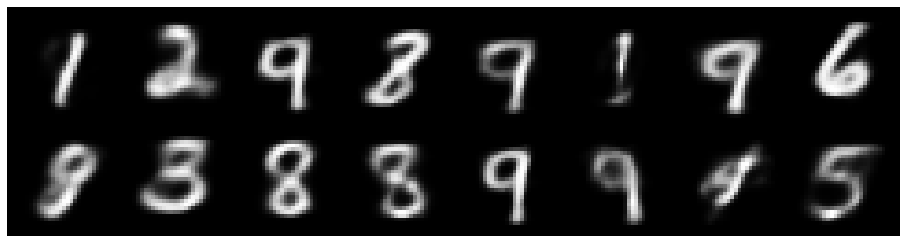

epoch : 16/20, loss = 93309.852488
epoch : 17/20, loss = 93129.348145
epoch : 18/20, loss = 93106.237203
epoch : 19/20, loss = 92906.064260
epoch : 20/20, loss = 92913.435384


In [27]:
for epoch in range(num_epochs): # loop over dataset
    loss_log = 0  
    for n_batch, (train_data, _) in enumerate(data_loader):  

        train_data  = Variable(train_data.view(-1, n_features))

        if has_gpu: train_data = train_data.cuda()

        # reset the gradients back to zero
        ae_optim.zero_grad()

        # compute reconstruction 
    
        reconstructed, mu, log_var = autoencoder(train_data)

        # compute the loss 
        bce_loss = loss(reconstructed, train_data)  

        train_loss = vea_loss(bce_loss, mu, log_var)

        # backpropagate the gradient 
        train_loss.backward()

        # update parameter update based on current gradients
        ae_optim.step()
        loss_log += train_loss.item()
    
    # Log the image
    if(epoch) % 5 == 0:
        display.clear_output(True)
        logger.log_images(images = vector_to_image(reconstructed[0:16]).data.cpu(), num_images = 16, epoch=epoch, n_batch = n_batch,  num_batches=batch_size)
    # epoch loss 
    loss_log = loss_log / len(train_data)

    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss_log))

In [29]:
def plot_images(model,
                image,
                show=True,
                step=0,
                model_name="auto_encoder"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        model (Models): 
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """

    constructed, _, _ = model(image)
    images = constructed.cpu().detach()
    print(model_name,
          "Labels for generated images: ")
    print("image size", images.shape)
    plt.figure(figsize=(12, 12))
    num_images = images.shape[0]
    image_size = 28
    
    rows =  int(np.sqrt(num_images))*2  #int(math.sqrt(noise_class.shape[0]))
    print("ROWS", rows)
    for i in range(num_images): 
        plt.subplot(rows, rows, i + 1)
        img2 = np.reshape(image[i].cpu().detach(), [image_size, image_size]) 
        plt.imshow(img2, cmap='gray')
        plt.axis('off')

        plt.subplot(rows, rows, num_images + i + 1)
        img = np.reshape(images[i], [image_size, image_size])  
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
    save_images(plt)
    if show:
        plt.show()
    else:
        plt.close('all')

In [31]:
data_subdir = 'mnist'
def make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
          print(e)
        #    if e.errno != errno.EEXIST:
        #       raise

def save_images(fig, epoch=0, n_batch=0, comment=''):
        out_dir = './data/images/{}'.format(data_subdir)
        make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir, comment, epoch, n_batch))

torch.Size([16, 784])
auto_encoder Labels for generated images: 
image size torch.Size([16, 784])
ROWS 8
[Errno 17] File exists: './data/images/mnist'


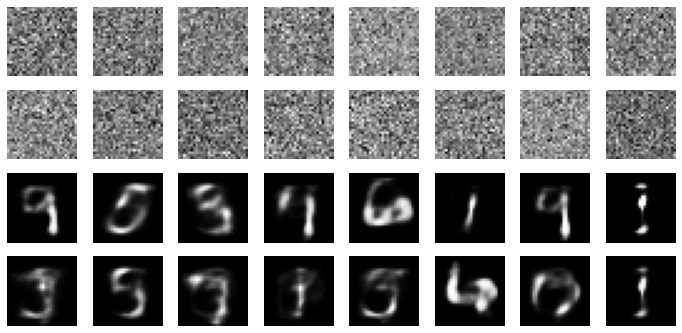

In [33]:
img = Variable(train_data[16:32].view(-1, n_features)) #Variable(train_dataset.train_data[0].view(-1, n_features)).cuda()

img = img.cuda()

img = torch.randn_like(train_data[0:16])

print(img.shape)
plot_images(autoencoder, img)